In [14]:
import numpy as np
import h5py

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, Dropout,  Activation, Conv3D, MaxPooling3D, UpSampling3D, BatchNormalization, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import multi_gpu_model

from keras.optimizers import SGD
from keras.layers.merge import concatenate, add

#from keras.utils.io_utils import HDF5Matrix
from keras.utils import plot_model
from keras import optimizers

import os
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from random import shuffle

In [2]:
def conv3d_block(input_tensor, filters, kernel_size, activation_fun = "linear"):
    # first layer
    x = Conv3D(filters=filters, kernel_size=kernel_size, kernel_initializer="he_normal", padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation_fun)(x)

    return x

kernel_size = (5,5,5)
act_fun = "relu"

############### DEFINE SET OF INPUTS #################

x = Input(shape=(8, 128, 128,3)) 


############## DEFINE PATH FOR INPUT 1 ##################


c1 = conv3d_block (x, filters=32, kernel_size=kernel_size, activation_fun = act_fun )
c1 = BatchNormalization()(c1)
p1 = MaxPooling3D (pool_size=(4, 4, 4), padding='valid')(c1)
p1 = Dropout(0.5)(p1)


c2 = conv3d_block(p1, filters=64, kernel_size=kernel_size, activation_fun = act_fun )
c2 = BatchNormalization()(c2)
p2 = MaxPooling3D(pool_size=(2, 4, 4), padding='valid')(c2)
p2 = Dropout(0.25)(p2)


c3 = conv3d_block(p2, filters=128, kernel_size=kernel_size, activation_fun = act_fun )
c3 = BatchNormalization()(c3)
p3 = MaxPooling3D(pool_size=(1, 2, 2), padding='valid')(c3)
p3 = Dropout(0.25)(p3)


p3 = Reshape((2048,))(p3)


d = Dense(2, activation = 'sigmoid')(p3)



model = Model(x , d)
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy())
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 128, 128, 3)]  0         
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 128, 128, 32)   12032     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 128, 128, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 8, 128, 128, 32)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 128, 128, 32)   128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 2, 32, 32, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 32, 32, 32)     0     

In [3]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, Directorio, batch_size = 5):
        
        self.batch_size = batch_size
        self.Directorio = h5py.File(Directorio)

    def __len__(self):
        
        return int((len(self.Directorio)/2) / self.batch_size)

    
    #Getitem nos devolvera los valores de X e Y para el indice de batch que le pida keras
    def __getitem__(self, index):
        
        #Creamos dos listas vacias en las que se separaran los valores de X e Y de nuestro archivo
        array_x = []
        array_y = []
        
        #Numero de ejemplos que tenemos en nuestro dataset, dividimos entre dos por que la longitud total
        #viene con el numero de X e Y
        self.indexes = np.arange(int(len(self.Directorio)/2))
        
        #dependiendo del indice de batch, indexes nos dara la posicion de los datos que queremos extraer
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        #Recorremos el directorio y extraemos las X con sus frames y las Y con sus estados
        for line in self.Directorio:

            if line[0] == 'X':
                array_x.append(self.Directorio[line])

            if line [0] == 'Y':
                array_y.append(self.Directorio[line])
        
        #dos nuevos listas en las que almacenaremos los datos correspondientes a las posiciones que nos pide
        #el indice del batch
        x = []
        y = []
        
        for i in indexes:
            x.append(array_x[i])
            y.append(array_y[i])
        
        #convertimos la lista anterior en un array con shape (batch_size,8,512,512,3)
        x_array = np.array(x)
        
        
        #Keras no entiende de strings, por lo que pasamos esos strings a vectores con numeros
        RE = [1,0] #vector para estado: reposo
        EA = [0,1] #vector para estado: ataque
        
        #lista donde almacenamos los vectores asociados a su string correspondiente
        y_strings = []
        
        for i in y:

            if i.value == 'RE':
                y_strings.append(RE)

            else:
                y_strings.append(EA)
                
        #convertimos la lista anterior en un array con shape (batch_size,2)
        y_array = np.array(y_strings)

        X, y = x_array,y_array

        return X,y

batch_size = 150


train_samples =  '/mnt/MD1200A/lconcha/videos/Datasets_training/Combinado_training_group32'
test_samples =  '/mnt/MD1200A/lconcha/videos/Datasets_training/Combinado_validation_group32'

training_generator   = DataGenerator(train_samples, batch_size )
validation_generator = DataGenerator(test_samples,  batch_size )

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


# COMPILE 

In [4]:
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


#####CHECK POINTS
checkpoint_path = "/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*batch_size,
                                                 verbose=1)


history = model.fit_generator(generator=training_generator,
                    steps_per_epoch= int((len(h5py.File(train_samples))/2))// batch_size,
                    epochs=50,
                    callbacks=[cp_callback],
                    verbose=True,
                    validation_data=validation_generator,
                    validation_steps=int((len(h5py.File(test_samples))/2))// batch_size,
                    use_multiprocessing=False,
                    workers=0,
                    max_queue_size=5)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site

Epoch 1/50
20/20 [==============================] - 1756s 88s/step - loss: 1.5781 - accuracy: 0.5710 - val_loss: 16.3799 - val_accuracy: 0.5800
Epoch 2/50
20/20 [==============================] - 1754s 88s/step - loss: 0.7222 - accuracy: 0.6404 - val_loss: 5.4576 - val_accuracy: 0.5811
Epoch 3/50
20/20 [==============================] - 1759s 88s/step - loss: 0.6713 - accuracy: 0.6705 - val_loss: 1.8076 - val_accuracy: 0.5244
Epoch 4/50
20/20 [==============================] - 1758s 88s/step - loss: 0.6359 - accuracy: 0.7024 - val_loss: 0.7637 - val_accuracy: 0.6389
Epoch 5/50
20/20 [==============================] - 1760s 88s/step - loss: 0.6285 - accuracy: 0.7103 - val_loss: 1.0268 - val_accuracy: 0.6433
Epoch 6/50
20/20 [==============================] - 2002s 101s/step - loss: 0.5879 - accuracy: 0.7282 - val_loss: 0.7222 - val_accuracy: 0.6956
Epoch 7/50
20/20 [==============================] - 1900s 94s/step - loss: 0.5905 - accuracy: 0.7166 - val_loss: 0.7778 - val_accuracy: 0.66

# SAVE MODEL

In [6]:
from keras.models import model_from_json

dirmodel = '/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/'

# Guardar configuración JSON en el disco
model_json = model.to_json()
with open(dirmodel + "dropout_05025025_32.json", "w") as json_file:
    json_file.write(model_json)
# Guardar pesos en el disco
model.save_weights(dirmodel + "dropout_05025025_32.h5")
print("Saved model to disk")

Saved model to disk


# LOAD MODEL

In [11]:
dirmodel = '/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/'

# Recargue el modelo de los 2 archivos que guardamos
with open(dirmodel + "dropout_05025025_32.json") as json_file:
    json_config = json_file.read()
new_model = keras.models.model_from_json(json_config)
new_model.load_weights(dirmodel + "dropout_05025025_32.h5")
print("Load model to disk")

Load model to disk


# TESTING PREDICTIONS

In [7]:
test_samples = '/mnt/MD1200A/lconcha/videos/Datasets_training/Combinado_test_group32'

#con esto vemos el numero de ejemplos que hay en el dataset de test
f = h5py.File(test_samples, 'r')
a_group_key = list(f.keys())
X_test = int(len(a_group_key)/2)


batch_size = X_test

test_generator = DataGenerator(test_samples, batch_size )

test_generator.batch_size = X_test
X, Y = test_generator.__getitem__(np.random.randint(0,1))
prediction = model.predict(X)

array_prediction = np.argmax(prediction, axis=1)
array_Y = np.argmax(Y, axis=1)

print(X.shape)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:58: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


(1014, 8, 128, 128, 3)


# GONFUSION MATRIX AND GRAPHS

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

[[441  48]
 [179 346]]
     RE   EA
RE  441   48
EA  179  346


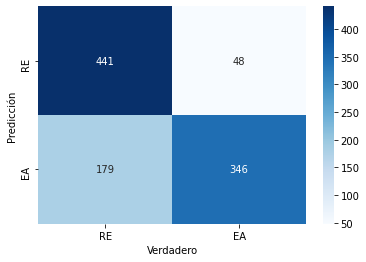

In [9]:
confm = confusion_matrix(array_Y,array_prediction)
print(confm)

columnas = ['RE','EA']
df_cm = pd.DataFrame(confm, index=columnas, columns=columnas)

print(df_cm)

grafica = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt="d")


plt.ylabel('Valores verdaderos')
plt.xlabel('Predicciones')
grafica.set(xlabel='Verdadero',ylabel='Predicción')
plt.show
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/confm_dropout05025025_32.png', dpi = 500)

[[0.43491124 0.04733728]
 [0.1765286  0.34122288]]
          RE        EA
RE  0.434911  0.047337
EA  0.176529  0.341223


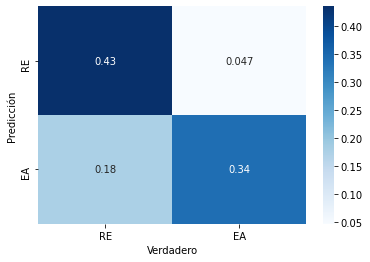

In [10]:
confm = confusion_matrix(array_Y,array_prediction)
confm = confm/1014
print(confm)

columnas = ['RE','EA']
df_cm = pd.DataFrame(confm, index=columnas, columns=columnas)

print(df_cm)

grafica = sns.heatmap(df_cm, cmap='Blues', annot=True)


plt.ylabel('Valores verdaderos')
plt.xlabel('Predicciones')
grafica.set(xlabel='Verdadero',ylabel='Predicción')
plt.show
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/%confm_dropout05025025.png', dpi = 500)

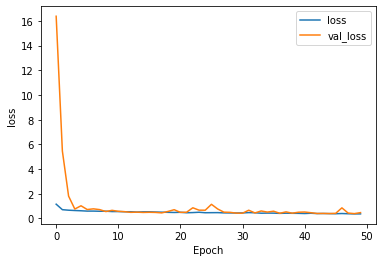

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/loss_dropout05025025_32.png', dpi = 500)

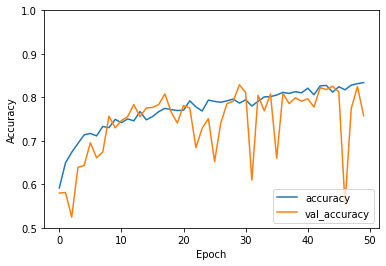

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/accuary_dropout05025025_32.png', dpi = 500)

In [13]:
#Con el siguiente codigo guardo los arrays de la matriz de confusion, los valores de loss y val_loss

with open('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/dropout_05025025_32.npy', 'wb') as f:
    np.save(f, confm)
    np.save(f, history.history['loss'])
    np.save(f, history.history['val_loss'])
    
with open('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025/Group32frames/dropout_05025025_32.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    c = np.load(f)
    
print(a, b,c)

[[0.43491124 0.04733728]
 [0.1765286  0.34122288]] [1.15547752 0.70998049 0.66817898 0.6431343  0.62233591 0.59504735
 0.5961532  0.58247769 0.58787823 0.55824065 0.55921584 0.54163516
 0.54371768 0.51752025 0.53626853 0.53813189 0.52085    0.50638896
 0.49559924 0.48375353 0.49842569 0.46089342 0.47590885 0.50211138
 0.46333024 0.46845907 0.47196561 0.45094368 0.44627139 0.44221935
 0.44751358 0.47376224 0.46119353 0.42483062 0.43431762 0.4300839
 0.41239899 0.42615813 0.4177489  0.41400611 0.3994734  0.42181298
 0.39654732 0.40040755 0.39195159 0.3810249  0.39910936 0.38128904
 0.36721337 0.37009728] [16.37988663  5.45757866  1.80763555  0.76370692  1.02676153  0.72217339
  0.77780545  0.71642768  0.55783862  0.65750217  0.57744789  0.55011028
  0.49504346  0.50946122  0.48629808  0.49919587  0.48726922  0.45095083
  0.56712645  0.70833302  0.49014816  0.50570673  0.86491358  0.67039788
  0.6676209   1.14508438  0.76698387  0.50954765  0.49471077  0.43167514
  0.4255946   0.66696149 